# SARIMA forecast

## 01 - Background

Our goal in this challenge is to apply the basic concepts of time series analysis on one-dimension data (sales depending on the date).

In this challenge, we'll go through the following steps : 
1. load and visualize the data;
2. train our models and make predictions;
3. use an econometric approach to model the serie and be able to forecast it;
4. use machine learning to hack this modelization.

The dataset is montly_champagne_sales

In [76]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

## 02 - Load Data
Let's start by loading the time series of the challenge

In [77]:
df=pd.read_csv('data/monthly_champagne_sales.csv')
df

,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946
...,...,...
100,1972-05,4618
101,1972-06,5312
102,1972-07,4298
103,1972-08,1413


👉 Convert dataframe with datetime objects as index to make it look like this
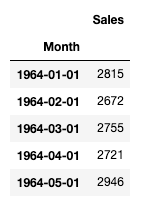

In [78]:
# Convert Month into Datetime
df['Month']=pd.to_datetime(df['Month'])

In [79]:
df.set_index('Month',inplace=True)

In [80]:
df.tail()

,Sales
Month,
1972-05-01,4618
1972-06-01,5312
1972-07-01,4298
1972-08-01,1413
1972-09-01,5877


## 04 - Visualize and interpet the data

Well done, thanks to this "reindexing", you should now be able to plot the "Sales" (y-axis) as a function of the time (x-axis) easily

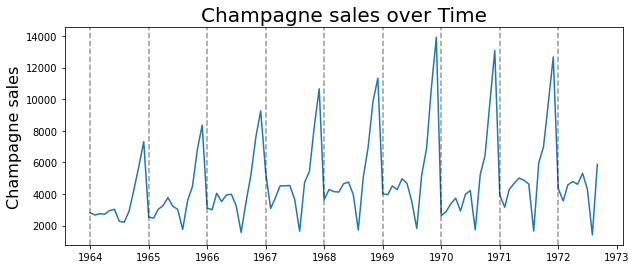

In [81]:
plt.figure(figsize=(10,4))
plt.plot(df["Sales"])
plt.title('Champagne sales over Time', fontsize=20)
plt.ylabel('Champagne sales', fontsize=16)
for year in range(1964,1973):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.4)

If your code is correct, you should be able to see that this Time Serie (TS) is:
- Not stationary (mean and variance are not constant).
- Exhibits strong seasonality.
- Seems to have a trend.

Let's see a decomposition of the data between **trend**, **saisonality** and **noise**. In order to do that, you have to make use of statsmodels [`seasonal_decompose`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html). Read the docs and make sure you understand what this function is doing and how to use it. Then:
1. plot the "Sales" with an "additive" model
2. plot the "Sales" with a "multiplicative" model

Pro tips: end your statsmodels plot method calls with a `;` to avoid double-plotting issues

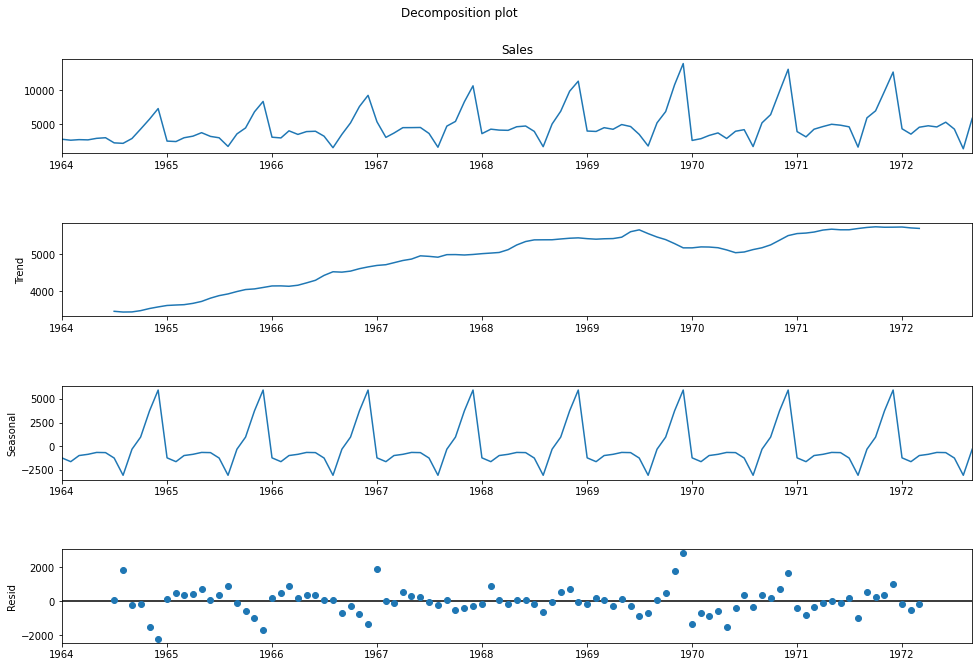

In [82]:
from statsmodels.tsa.seasonal import seasonal_decompose
import  statsmodels.api as sm
decompSale_df = sm.tsa.seasonal_decompose(df.Sales, model="additive")
fig = decompSale_df.plot()
fig.set_size_inches(15,10)
fig.suptitle('Decomposition plot')
plt.show()

In [83]:
trend = decompSale_df.trend
seasonal = decompSale_df.seasonal
residual = decompSale_df.resid

In [84]:
print(trend.head(12))
print(seasonal.head(12))
print(residual.head(12))

Month
1964-01-01            NaN
1964-02-01            NaN
1964-03-01            NaN
1964-04-01            NaN
1964-05-01            NaN
1964-06-01            NaN
1964-07-01    3466.750000
1964-08-01    3447.125000
1964-09-01    3450.416667
1964-10-01    3484.625000
1964-11-01    3541.916667
1964-12-01    3584.583333
Name: trend, dtype: float64
Month
1964-01-01   -1223.411582
1964-02-01   -1624.250124
1964-03-01    -979.229291
1964-04-01    -850.244916
1964-05-01    -652.096106
1964-06-01    -671.173487
1964-07-01   -1242.500124
1964-08-01   -3060.505332
1964-09-01    -312.390749
1964-10-01     965.729043
1964-11-01    3730.130084
1964-12-01    5919.942584
Name: seasonal, dtype: float64
Month
1964-01-01            NaN
1964-02-01            NaN
1964-03-01            NaN
1964-04-01            NaN
1964-05-01            NaN
1964-06-01            NaN
1964-07-01      57.750124
1964-08-01    1825.380332
1964-09-01    -216.025918
1964-10-01    -149.354043
1964-11-01   -1508.046751
1964-12-01   

Multiplicative model

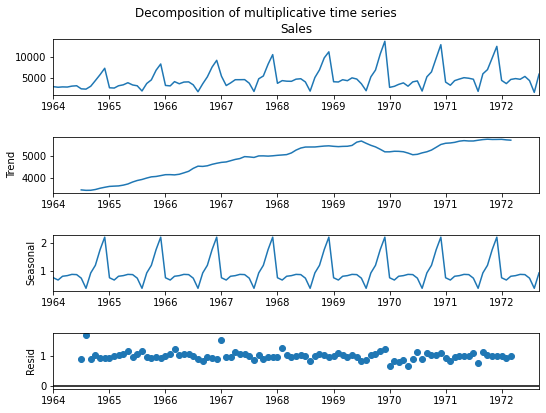

In [85]:
decompSale_df1 = sm.tsa.seasonal_decompose(df.Sales, model="multiplicative")
fig = decompSale_df1.plot()
fig.set_figwidth(8)
fig.set_figheight(6)
fig.suptitle('Decomposition of multiplicative time series')
plt.show()

In [86]:
seasonal = decompSale_df1.seasonal
seasonal.head(4)

Month
1964-01-01    0.754627
1964-02-01    0.674224
1964-03-01    0.807685
1964-04-01    0.829951
Name: seasonal, dtype: float64

👉 De-seasonalize this time serie using the decomposition of your choice

In [87]:

df["seasonal"] = seasonal

In [88]:
df

,Sales,seasonal
Month,,
1964-01-01,2815,0.754627
1964-02-01,2672,0.674224
1964-03-01,2755,0.807685
1964-04-01,2721,0.829951
1964-05-01,2946,0.874299
...,...,...
1972-05-01,4618,0.874299
1972-06-01,5312,0.866200
1972-07-01,4298,0.740520


Text(0.5, 1.0, 'Time series without seasonality')

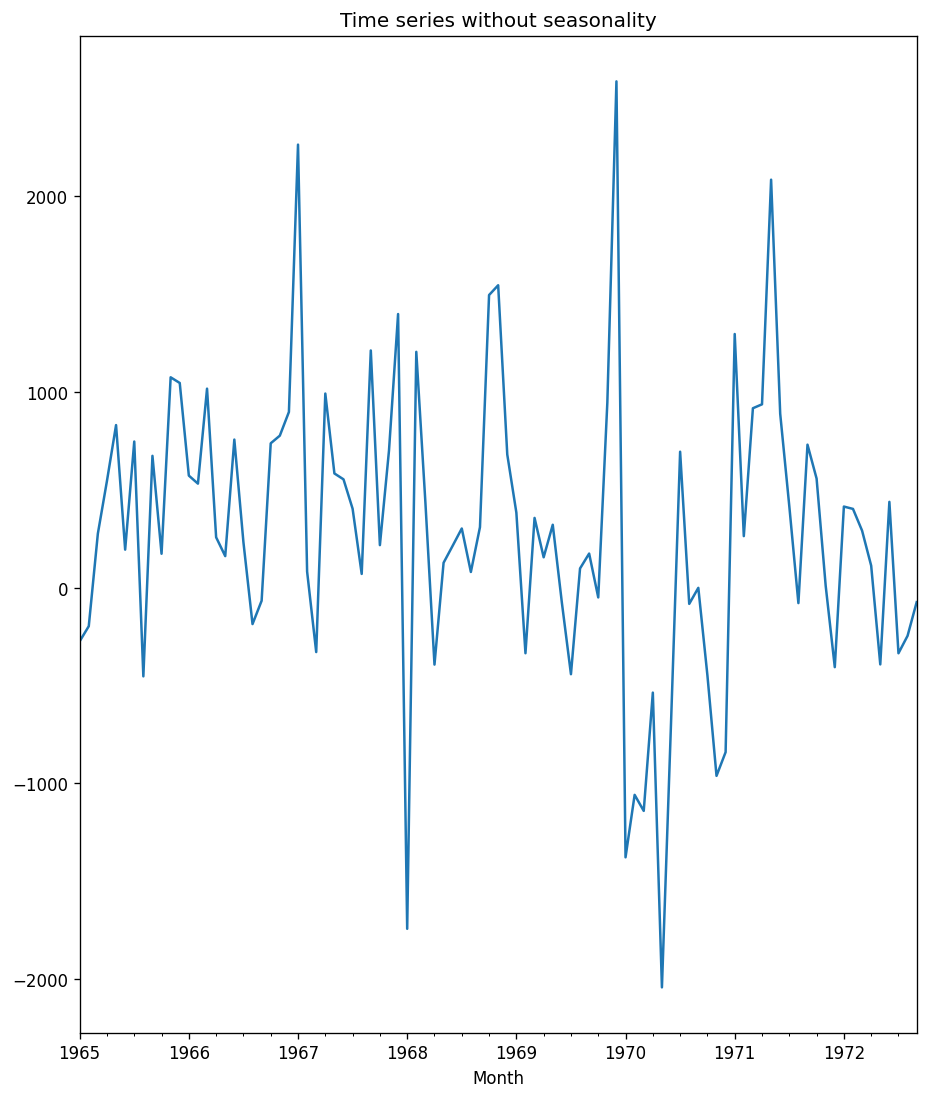

In [103]:
seasonal_diff_ts = df['Sales'] - df['Sales'].shift(12)
seasonal_diff_ts.dropna(inplace  =True)
seasonal_diff_ts.plot()
plt.title('Time series without seasonality')

In [90]:
dfuller(seasonal_diff_ts)

Test Statistic :  -7.626619157213166
p-value :  2.0605796968136632e-11
no. of lags Used :  0
Number of Observations Used :  92
critical values:  {'1%': -3.503514579651927, '5%': -2.893507960466837, '10%': -2.583823615311909}


☝️ We could fit an ARIMA model on a "de-seasonalized" version of this time serie, and then re-compose it back after our forecast. But in this challenge, we will use SARIMA models to _directly_ fit the original time serie!

## 05 - Split the data (train/test)


For time series, we cannot randomly sample points to be in the test set. The test set needs to be "out-of-time", that is, strictly in the future of the test set. For the purpose of this exercise, we will use data up to 1970 for training and after for the test.

👉 create `df_train` and `df_test`, splitting the DataFrame before 1970 for the training and after (or equal to) for the testing

In [92]:
df_train = (df[df.index <= '1970-12-31'])
df_test = (df[df.index >= '1970-12-31'])
print('train examples: ', df_train.shape[0])
print('test examples: ', df_test.shape[0])


train examples:  84
test examples:  21


## 06 - SARIMA
We will analyse the data using a SARIMA model (Seasonal Auto Regressive Integrated Moving Average).


We need to :
- find how to stationarize the time serie (I in SARIMA)
- find the auto-regressive (AR) part
- find the Moving-Average (MA) part
- find the seasonality (S)

### Step 1: Check stationarity

If a time series has a trend or seasonality component, it must be made stationary before we can use ARIMA to forecast.

A quick glance at the plot above should be sufficient to convince you that the time serie is not stationary.

Double check the stationarity of `df["Sales"]` using the [`Augmented Dick Fuller test`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html) and especially its p-value

In [93]:
from statsmodels.tsa.stattools import adfuller
dfstest = adfuller(df.Sales)
dfstest

(-1.8335930563276188,
 0.363915771660247,
 11,
 93,
 {'1%': -3.502704609582561,
  '5%': -2.8931578098779522,
  '10%': -2.583636712914788},
 1478.4633060594724)

In [104]:
from statsmodels.tsa.stattools import adfuller
def dfuller(series):
    dftest = adfuller(series, autolag='AIC')
    values_names = ['Test Statistic','p-value','no. of lags Used','Number of Observations Used']
    for value_name,value in list(zip(values_names,dftest)):
        print(value_name,': ', value)
    print('critical values: ',dftest[4])

In [105]:
dfuller(df.Sales)

Test Statistic :  -1.8335930563276188
p-value :  0.363915771660247
no. of lags Used :  11
Number of Observations Used :  93
critical values:  {'1%': -3.502704609582561, '5%': -2.8931578098779522, '10%': -2.583636712914788}


The p-value should be less than 0.05 to have a 95% confidence in the stationarity.  

If the p-value is larger than 0.05, we cannot reject the null hypothesis (null hypothesis = "the process is not stationary").

Ideally, p is *much* smaller than 0.05.

Another way to look for stationarity, is to look at the autocorrelation function (ACF).

Plot the ACF of the time series. You should see a large peak at lag 12, indicating strong yearly seasonality.

In [106]:
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

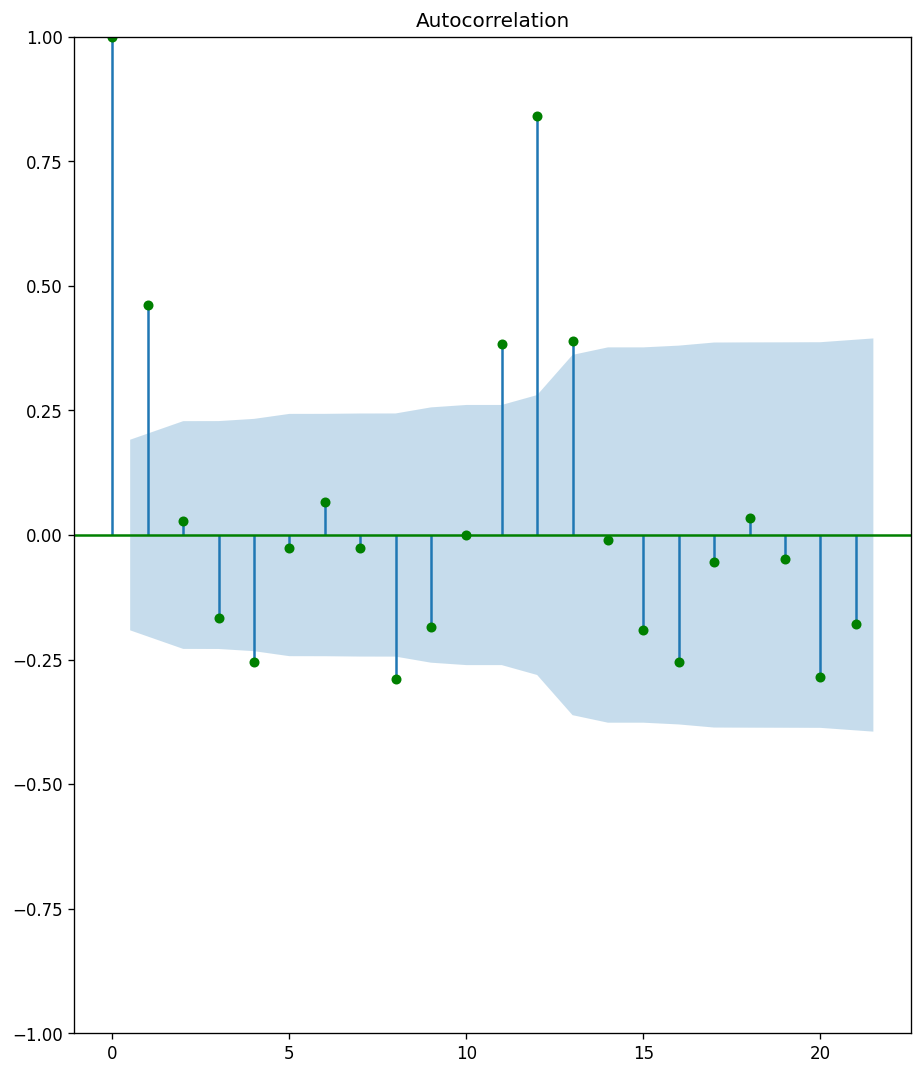

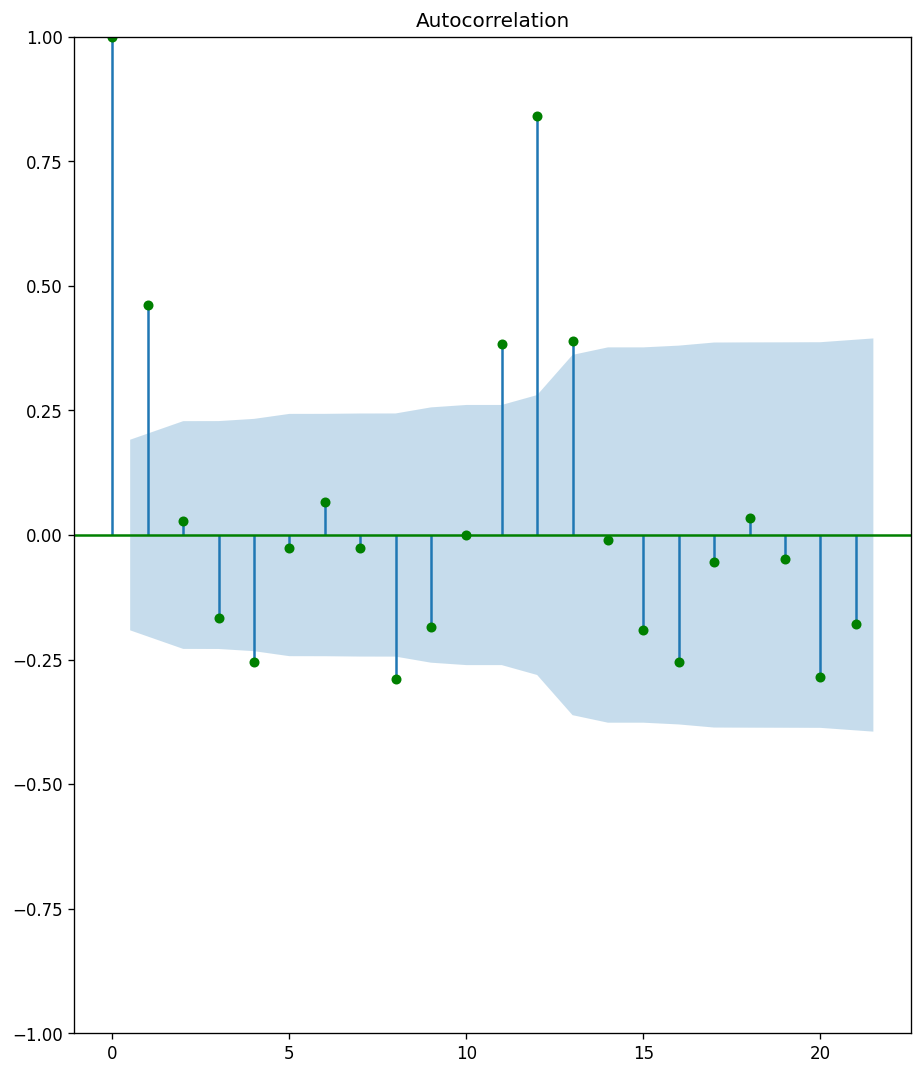

In [107]:
plot_acf(df['Sales'], ax=plt.gca(), color ='green')

### Step 2 - Seasonal differencing (D)

We have a strong seasonality with a period of 12 months.

Do a **seasonal differencing of lag 12** on the time series, and plot the differenced data and check the ACF plot (+ADF test) again.

Don't forget to drop NaN's.

In [108]:
ts_acf = acf(seasonal_diff_ts,nlags=40)
ts_pacf = pacf(seasonal_diff_ts,nlags =40)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


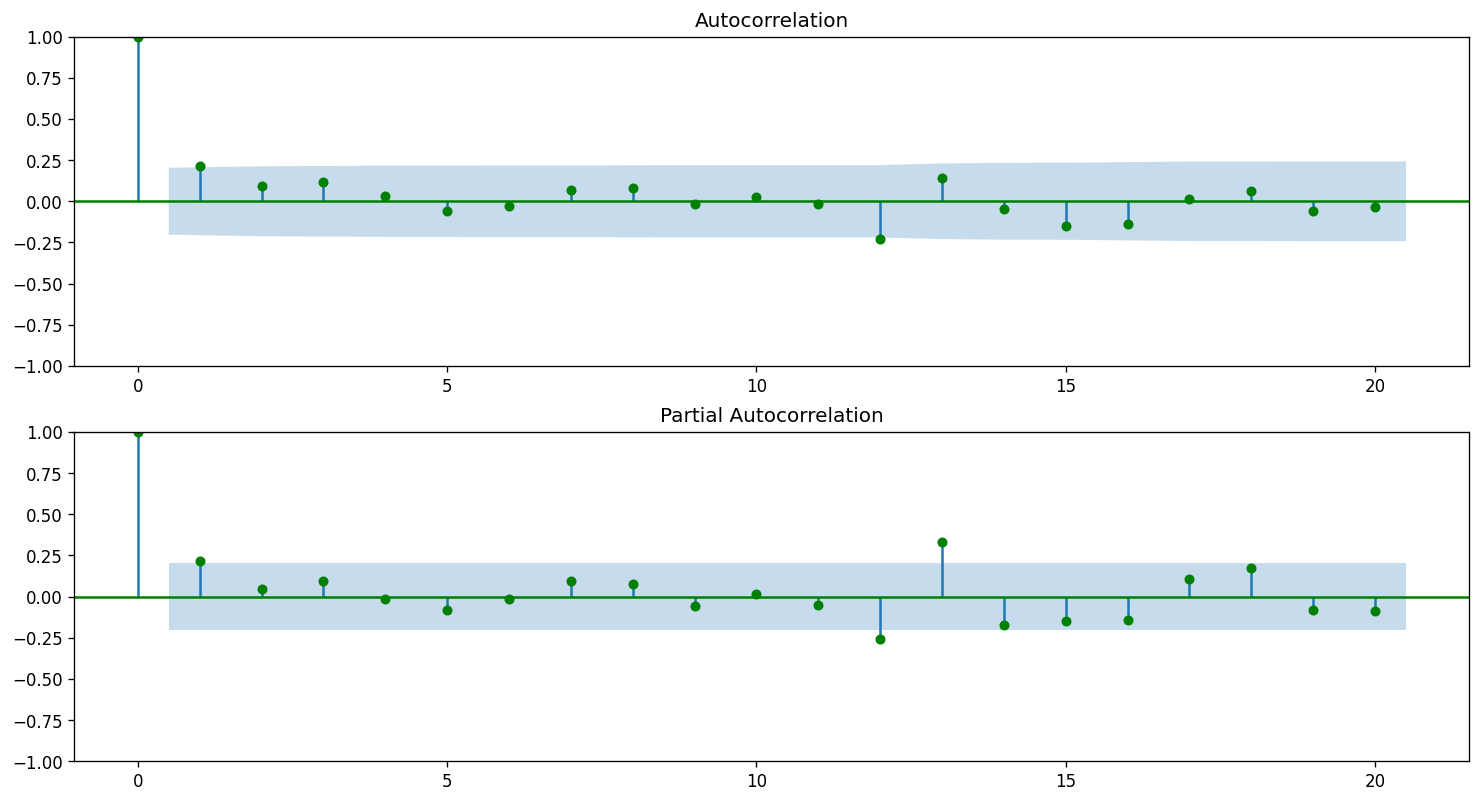

In [110]:
plt.figure(figsize = (15,8))
plt.subplot(211)
plot_acf(seasonal_diff_ts, ax=plt.gca(), color ='green')
plt.subplot(212)
plot_pacf(seasonal_diff_ts, ax=plt.gca(),  color ='green')
plt.show()

In [100]:
dfuller(df_train.Sales)

Test Statistic :  -2.2955542605529793
p-value :  0.1734058202954754
no. of lags Used :  11
Number of Observations Used :  72
critical values:  {'1%': -3.524624466842421, '5%': -2.9026070739026064, '10%': -2.5886785262345677}


☝️ One single seasonal differencing seems enough to stationarize the TS.  
D=1 (1 seasonal diff) and m=12 (seasonality = 12) for SARIMA(p,d,q, P,D,Q,m)

### Step 3 - Differencing (d)

If the time series is still not stationary, it needs to be stationarized through *differencing*. It means that we take the difference between each value and the preceding one (*first difference*).

Do we need further differencing after removing the seasonality?

Check the ACF and ADF after running an additional first order diff(1) on your diff(12) series.

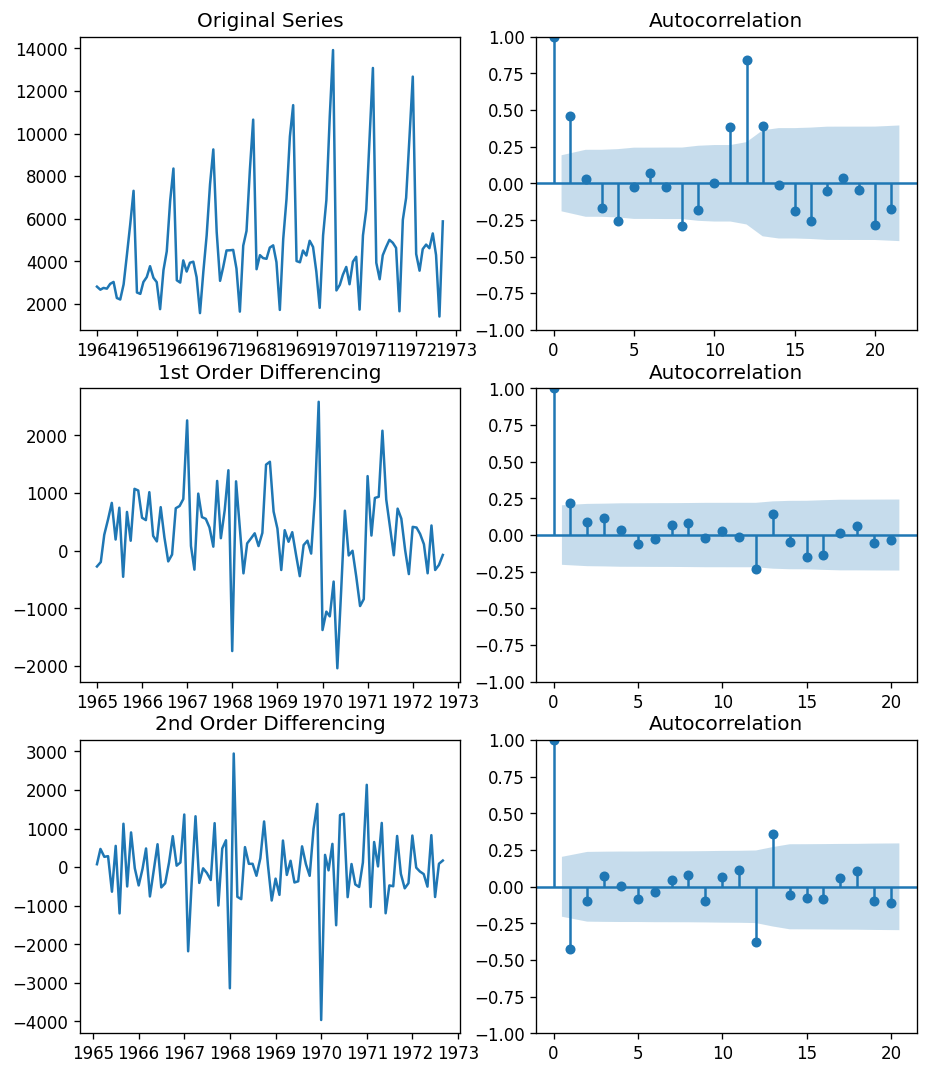

In [111]:
plt.rcParams.update({'figure.figsize':(9,11), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=False)
axes[0, 0].plot(df.Sales); axes[0, 0].set_title('Original Series')
plot_acf(df.Sales, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.Sales.diff(12)); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.Sales.diff(12).dropna(), ax=axes[1, 1]); 


# 2nd Differencing
axes[2, 0].plot(df.Sales.diff(12).diff(1)); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.Sales.diff(12).diff(1).dropna(), ax=axes[2, 1])

plt.show()

👉 Additional differencing actually made both the p-value and the ACF look worse! 
We can select (d=0) and (D=1)

### Step 4 - Select AR(p,P) and MA(q,Q) terms

You will now use the ACF and PACF plots to decide whether to include an AR term(s), MA term(s), or both.





- The autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) applied to your **fully differentiated** series allows you to select MA number (`q`)
- MA($\color{blue}{q}$) = number of lag beyond which the $\color{blue}{ACF}$ of  $Y^{\color{green}{(d+D)}}$ cuts off


- The partial autocorrelation plot [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) applied to your **fully differentiated** series allows you to select AR (`p`)
- AR($\color{red}{p}$) = number of lags beyond which the $\color{red}{PACF}$ of $Y^{\color{green}{(d+D)}}$  cuts off

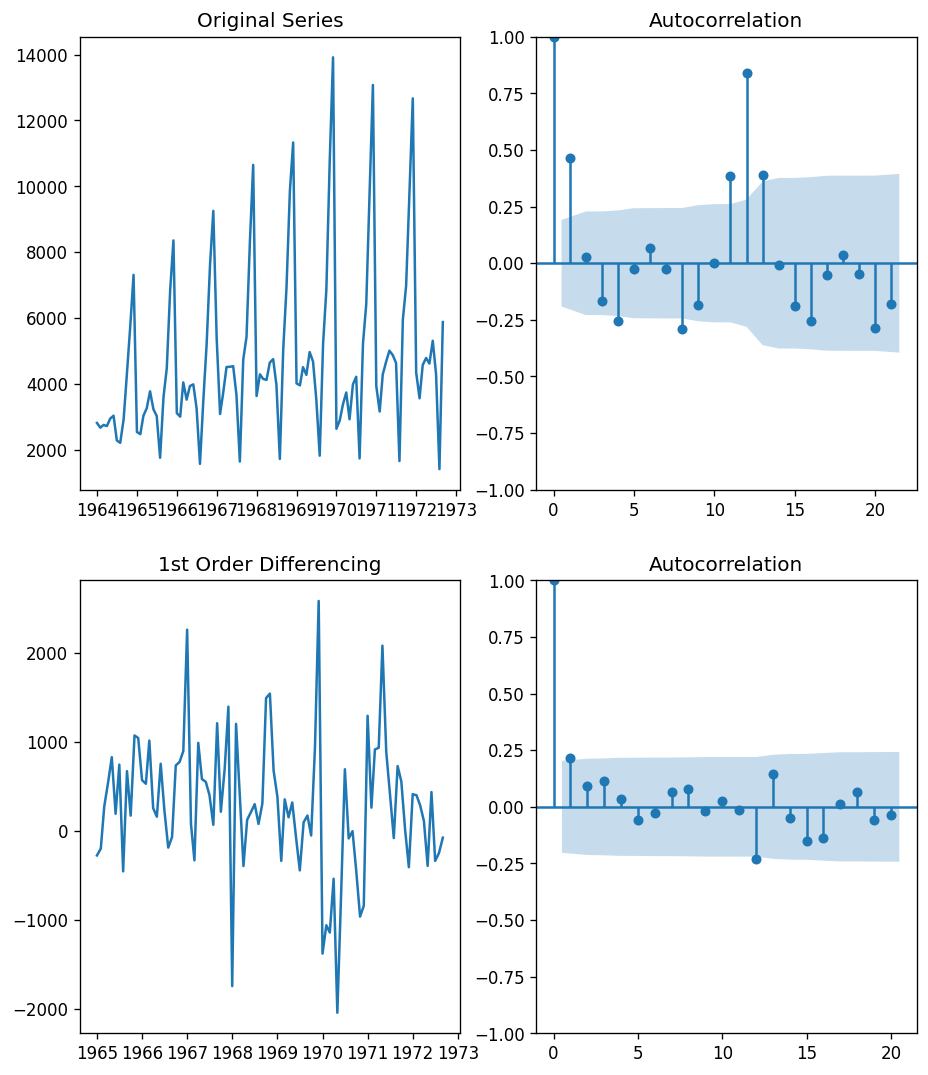

In [112]:
plt.rcParams.update({'figure.figsize':(9,11), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(2, 2, sharex=False)
axes[0, 0].plot(df.Sales); axes[0, 0].set_title('Original Series')
plot_acf(df.Sales, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.Sales.diff(12)); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.Sales.diff(12).dropna(), ax=axes[1, 1]); 
plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


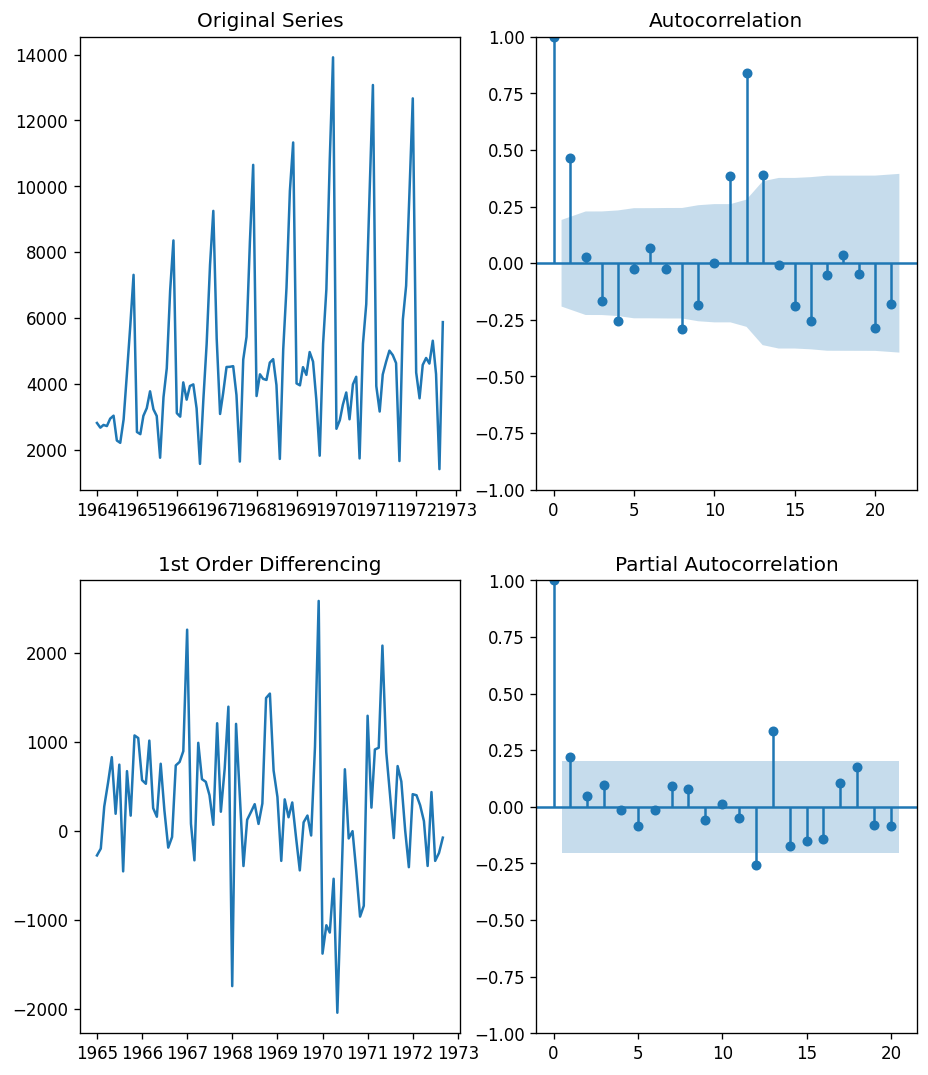

In [75]:
plt.rcParams.update({'figure.figsize':(9,11), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(2, 2, sharex=False)
axes[0, 0].plot(df.Sales); axes[0, 0].set_title('Original Series')
plot_acf(df.Sales, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.Sales.diff(12)); axes[1, 0].set_title('1st Order Differencing')
plot_pacf(df.Sales.diff(12).dropna(), ax=axes[1, 1]); 
plt.show()

☝️ It seems like there are no significant peaks in either ACF or PACF, so most likely p=q=0.  
Our first guess for SARIMA is therefore d=0, p=q=0, D=1 and m=12.  

How to find values for P and Q? Here, we will let pdarima try values 1 and 0 for P and Q with a grid_search for us.
If you really want to find these coefficient by yourself, [Read here 🤯 ](https://www.datasciencecentral.com/profiles/blogs/tutorial-forecasting-with-seasonal-arima) for some rules of thumb

👉 Run [auto_arima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) for the training set. set seasonal=True, m=12 and D=1. Search for p and q, P and Q from 0 to 2. Then, print the summary of the model with model.summary().
Use `njobs=-1, trace=True, error_action='ignore', suppress_warnings=True`

In [113]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
model = pm.auto_arima(df_train.Sales, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, max_P=2,
                      start_Q=0, max_Q=2,
                      D=1,
                      n_jobs=-1,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1169.871, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1171.619, Time=0.12 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1171.569, Time=0.51 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1174.921, Time=0.02 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1171.871, Time=0.05 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1171.871, Time=0.06 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=1173.871, Time=0.23 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1169.907, Time=0.07 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=1169.936, Time=0.08 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=1171.947, Time=0.25 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 1.501 seconds
                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:                   84
Model:             SARIMAX(0, 1, 0, 12)   Log L

The best model found is `ARIMA(0,0,0)(0,1,0)[12]` ! 
This means that the Time Serie condidered does not justify adding any "autoregressive" nor "moving average" modelling beyond simple "seasonal differencing".

Such "poor" model is only likely to predict a repetition of the last seasonal pattern detected, alongwith the prolongation of the mean increasing trend. Let's check it out

👉 Use `model.predict` with `n_periods` = length of the test set, in order to save the following three predictions
- `central`
- `upper`
- `lower`

Save them as Pandas Series, and index them by the same index than your `y_test`

In [114]:
prediction, confint = model.predict(n_periods = len(df_test),return_conf_int=True, index=df_test.index)
#index_of_fc = pd.date_range(df_test.index[-1], periods = len(df_test), freq='MS')

In [115]:
# make series for plotting purpose
central = pd.Series(prediction, index=df_test.index)
lower = pd.Series(confint[:, 0], index=df_test.index)
upper = pd.Series(confint[:, 1], index=df_test.index)


👇 Run the cell below to plot your predictions against reality

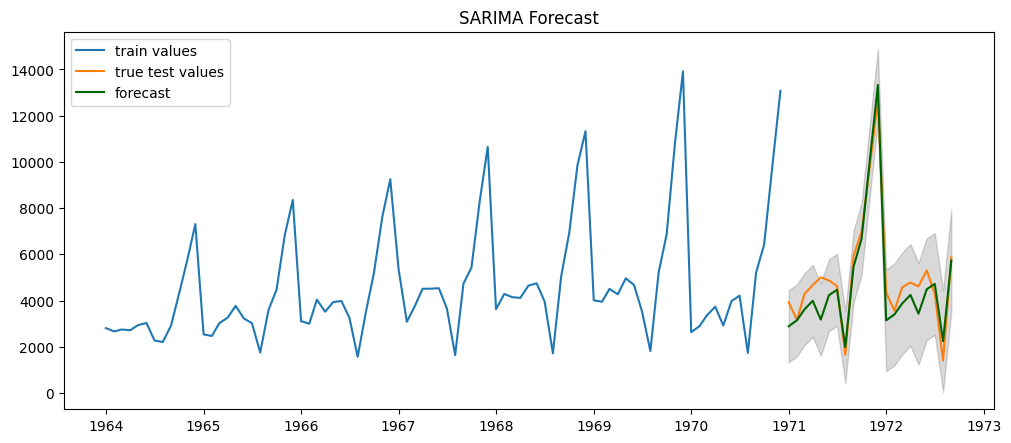

In [116]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train.Sales, label = "train values");
plt.plot(df_test.Sales, label = "true test values");
plt.plot(central, color='darkgreen',label = "forecast");
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15);

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

👉 Try to assign non-null values to  `p`,`d`,`P`,`D` on your SARIMA and re-plot this chart to compare effects!

# OPTIONAL - Machine Learning Approach

### Model with forecast horizon = 1 month only

We will now fit a non linear model such as a random forest. The idea is to predict a value from the last ones. 

👉 Create new columns in `df` that are shifted version of `df['Sales']`. Do it with a shift from 1 to 12.

In [ ]:
# Add lagged values

# Drop nan


# create df_train and df_test 


In [ ]:
# Keep track of test_indexes

In [ ]:
# Create X, y

👉 Instanciate (don't train) a `random forest` algorithm to predict Sales based in your shifted features

👉 You can use the following function to test it. It takes the true y values (`data` which should be a Numpy array), the indexes of the test samples (`test_indexes`), the predictor (`predictor`: your random forest algorithm) and the shifted columns (`full_X` which should be a Numpy array).

In [ ]:
# For each predictor, design a method to evaluate its performance on the test set:
from sklearn.metrics import r2_score
def evaluate_performance_month_prediction(y_true, test_indexes, predictor, full_X):
    predictions = []
    ground_truth = []
    i = 0
    for _indx in test_indexes:
        train_data = y_true[:_indx]
        current_ground_truth = y_true[_indx]
        current_ground_truth_features = full_X[_indx,:]
        train_features = full_X[:_indx]
        # train the model on all datapoint until (t-1) in order to predict (t)
        predictor.fit(train_features, train_data)
        prediction = predictor.predict(current_ground_truth_features.reshape(1,-1))[0]
        predictions.append(prediction)
        ground_truth.append(current_ground_truth)
        i += 1
    mape = np.mean(np.abs(np.array(predictions) - np.array(ground_truth))/np.abs(np.array(ground_truth)))
    return ground_truth, predictions, mape

In [ ]:
results = evaluate_performance_month_prediction(y.values, test_indexes=test_indexes,
                                                         predictor=random_forest, full_X = X.values)

In [ ]:
print('Mean Absolute Prediction Error MAPE')
results[2]

In [ ]:
plt.plot(results[0], c='black', label='test set')
plt.plot(results[1], c='orange', label='forecast (horizon = 1)')
plt.legend()

To improve our model, we can do some feature engineering. You will add moving averages to the data used to train the random forest.

Try to create 3 new columnns in `df`: one which is the rolling average of `df[Sales]` with a window of 12, one with a window of 3, and one with a window of 2. This will have the effect to isolate the trend and allow the algorithm to learn it. Also, plot these data.


In [ ]:
# Extract the trend using a well chosen moving average

You can also add a more smoothing predictor using the exponential moving average (hint: method `.ewm` with `halflife` of 2, 3 and 12), that statistically optimizes an AR process. Plot also the data.

You should see a better MAPE!

Try to look at the importance of each feature. What do you find?


### Out-of-sample forecast models

Let's now try to beat SARIMA in the "out-of-sample" prediction. 

👉 Train _one model per horizon of forecast_ (from `1` month horizon to `len(y_test)` months)  
👉 Evaluate MAPE and compare with SARIMA